In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import seaborn as sns
from googletrans import Translator


In [2]:
image_folder_path = "C:/Users/louis/github_vs/113_data/"

years = os.listdir(image_folder_path)
post_chat = years[5]
pre_chat = years[6]
years = years[0:5]
print(years)

['2017', '2018', '2019', '2020', '2021']


In [ ]:

df_all = pd.DataFrame(columns =['event_id', 'message_id', 'user_handle', 'sec_since_start']);
for y in years:
    
    events =  os.listdir(image_folder_path+y)

    for e in events:
        df = pd.read_csv(image_folder_path+y+'/'+e+'/'+"message_info.tsv",sep= '\t')
        df_all = df_all.merge(df, how = "outer")
        
df_all["id"] = df_all["event_id"].astype("string") + df_all["message_id"].astype("string")
df_all=df_all.set_index("id")
# group by the messages by conversation
df_group = df_all.groupby("event_id")

# df_all.drop(['event_id','message_id'],axis=1,inplace=True)
df_all

In [63]:
# total number of conversations
print(len(df_group))

166685


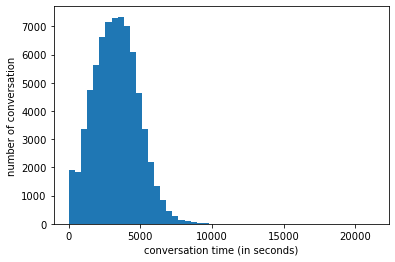

In [67]:
# plot the conversation length
event_lengths = []

for name, group in df_group:
    event_lengths.append(np.max(group["sec_since_start"]))

a =plt.hist(x =event_lengths, bins = 50)
plt.xlabel("conversation time (in seconds)")
plt.ylabel("number of conversation")
plt.show()

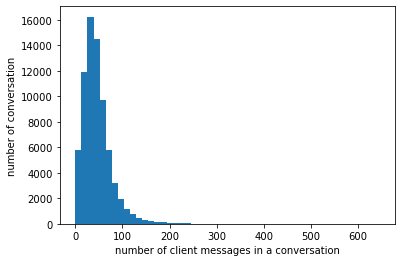

In [70]:
# plot the number of messages per conversation
client_messages = []

for name, group in df_group:
    client_messages.append(len(group[group["user_handle"]== "client"]))
    
a =plt.hist(x =client_messages, bins = 50)
plt.xlabel("number of client messages in a conversation")
plt.ylabel("number of conversation")
plt.show()

In [73]:
print("correlation between conversation time and message number",str(np.corrcoef(event_lengths, client_messages)[0,1]))
# obviously, the longer the conversation is, the more likely it is that they are more messages from the client

correlation between conversation time and message number 0.635961507054393


In [43]:
df_all

,event_id,message_id,user_handle,sec_since_start
id,,,,
cl0709090,cl070909,0,system_1,0.0
cl0709091,cl070909,1,employee03119,9.0
cl0709092,cl070909,2,client,44.0
cl0709093,cl070909,3,employee03119,64.0
cl0709094,cl070909,4,system_8,70.0
...,...,...,...,...
cl0020693,cl002069,3,system_7,20.0
cl0020694,cl002069,4,employee00008,25.0
cl0020695,cl002069,5,client,77.0


In [35]:
df_cds_per_time = pd.DataFrame(columns =['sec_since_start_norm','sum']);

bins_nb = 100
bins = np.linspace(0, 1, bins_nb)
all_sums = np.zeros(bins_nb)

for y in years:
    print("year =",y)
    events =  os.listdir(image_folder_path+y)

    for e in events:
    # do stuff here for all the years and events. Unfortunately, the data is too heavy to be put in the same df

        df = pd.read_csv(image_folder_path+y+'/'+e+'/'+"CDS_results.tsv",sep= '\t')
        df["id"] = df["event_id"].astype("string") + df["message_id"].astype("string")
        df=df.set_index("id")
        df.drop(['event_id','message_id'],axis=1,inplace=True)
        
        dm = df.join(df_all)
        max = dm.groupby("event_id").transform("max")
        new_df = pd.DataFrame(columns =['sec_since_start_norm','sum'])
        new_df['sec_since_start_norm'] = dm['sec_since_start']/max['sec_since_start'] # normalize the time by the conversation length
        new_df['sum'] = dm.drop(['event_id','message_id','user_handle','sec_since_start'],axis=1).sum(axis = 1)
        groups = new_df.groupby(np.digitize(new_df.sec_since_start_norm, bins)) # grouping per time bin
        sums = groups.sum()['sum'] # cumulative sum of the CDS per time bin
        all_sums = all_sums + sums.values # summing with the previous data folders
    print("-------------------------------------------------------")


year = 2017
-------------------------------------------------------
year = 2018
-------------------------------------------------------
year = 2019
-------------------------------------------------------
year = 2020
-------------------------------------------------------
year = 2021
-------------------------------------------------------


Text(0, 0.5, 'number of CDS')

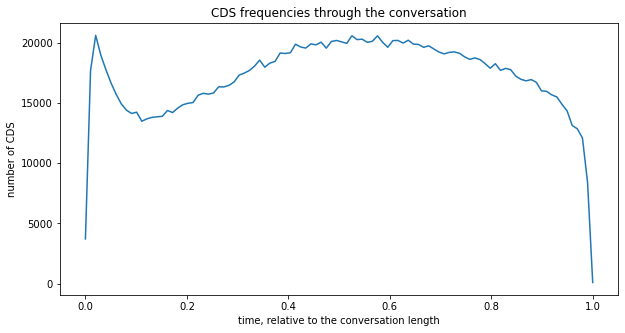

In [37]:
plt.figure(figsize=(10,5))
plt.title("CDS frequencies through the conversation")
plt.plot(bins, all_sums)
plt.xlabel('time, relative to the conversation length')
plt.ylabel('number of CDS')



In [4]:
# translation of CDS in English
translator = Translator()

# regex formatting and translation of the columns
def translate_cols(cols):
    cols_en = []
    for col in cols:
        col_en = [col+';']
        for b in re.findall('\(.*?\)', col):
            bz = b.replace('(','').replace(')','')
            if "+" in b: # removing the expression ( .+| )
                a = []
                [a.append(c.replace(b," ")) for c in col_en]
                col_en = a
            elif '|' in b: # creating a pair of expressions, one with the first part and one with the second part
                l = bz.split('|')[0]
                ls = []
                [ls.append(c.replace(b,l)) for c in col_en]
                r = bz.split('|')[1]
                rs = []
                [rs.append(c.replace(b,r)) for c in col_en]
                
                col_en = ls + rs
            else: # creating a pair of expressions, one with the string within the brackets and one without
                ls = []
                [ls.append(c.replace(b,bz)) for c in col_en]
                rs = []
                [rs.append(c.replace(b,"")) for c in col_en]
                col_en = ls + rs
                
        concat = " ".join(col_en) 
        cols_en.append( translator.translate(concat,src='nl').text ) # translating the different expressions
    return cols_en

# cols = df.columns
# df.columns = translate_cols(cols)

In [5]:
# pre/post chat questions data
df_post= pd.read_csv(image_folder_path+"postchat_questions.tsv",sep= '\t').dropna()
df_post = df_post.set_index("event_id")
df_pre = pd.read_csv(image_folder_path+"prechat_questions.tsv",sep= '\t').dropna()
df_pre = df_pre.set_index("event_id")
df_diff = df_post- df_pre
df_diff = df_diff.dropna()
df_diff.columns = translate_cols(df_diff.columns)


In [19]:
df_diff

,I tend to kill myself;,I can't take my pain anymore;,I am able to kill myself;,I am a burden to others;,I feel like I'm stuck;,I have the will to live;,I'm hopeless;,I don't belong anywhere;,I feel like I've given up;
event_id,,,,,,,,,
cl000003,-2.0,-2.0,-2.0,0.0,-3.0,0.0,-2.0,-1.0,0.0
cl000006,-1.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
cl000031,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cl000037,-1.0,-1.0,-1.0,-1.0,-3.0,3.0,-3.0,-2.0,-2.0
cl000044,-3.0,-3.0,0.0,-4.0,-3.0,3.0,-5.0,-6.0,-6.0
...,...,...,...,...,...,...,...,...,...
cl024825,-3.0,-2.0,-3.0,-2.0,-2.0,0.0,-4.0,-3.0,-4.0
cl024829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cl024834,-1.0,-1.0,0.0,-1.0,-1.0,1.0,-2.0,-2.0,-1.0


In [90]:
cm = sns.diverging_palette(120, 220, s=80, l=55, n=9, as_cmap=True)

a = df_diff.describe()
a = a.drop(['count','std','25%','50%','75%','min','max']).transpose
a.columns = ['post-prequestions difference averages']
a = a.style.background_gradient(cmap=cm).set_precision(2)
a

<ipython-input-90-102ee1199098>:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  a = a.style.background_gradient(cmap=cm).set_precision(2)


,post-prequestions difference averages
I tend to kill myself;,-1.16
I can't take my pain anymore;,-0.92
I am capable of killing myself;,-0.82
I am a burden to others;,-0.87
I feel like I'm stuck;,-1.15
I have the will to live;,0.69
I'm hopeless;,-1.32
I don't belong anywhere;,-0.69
I feel like I've given up;,-0.99


In [97]:
all_corrs = df_diff.corr()

all_corrs_list = []
i = 0;
for col in all_corrs.columns:
    i+=1;
    for row in all_corrs.index[i:]:
            all_corrs_list.append((col, row, abs(all_corrs[col][row])))
        
sorted_list = list(sorted(all_corrs_list,key = lambda i: i[2]))

In [102]:
print("The most uncorrelated responses")
for i in range(len(sorted_list)-5,len(sorted_list)):
    print(sorted_list[len(sorted_list)-i])

The most uncorrelated responses
('I am capable of killing myself;', 'I have the will to live;', 0.294623311132407)
('I have the will to live;', "I'm hopeless;", 0.27167336827107536)
("I feel like I'm stuck;", 'I have the will to live;', 0.2704364188483579)
('I am a burden to others;', 'I have the will to live;', 0.24508819378290497)
("I can't take my pain anymore;", 'I have the will to live;', 0.233858182852709)


In [101]:
print("The most correlated responses")
for i in range(1,6):
    print(sorted_list[len(sorted_list)-i])

The most correlated responses
('I tend to kill myself;', 'I am capable of killing myself;', 0.6726487188279244)
("I feel like I'm stuck;", "I feel like I've given up;", 0.6558904216400067)
("I can't take my pain anymore;", "I'm hopeless;", 0.6528751080022416)
("I feel like I'm stuck;", "I'm hopeless;", 0.6448692664426627)
('I am a burden to others;', "I'm hopeless;", 0.6100027689847964)


In [6]:
df_pre['cds sums'] =  pd.Series(np.zeros(len(df_pre))).values

for y in years:
    print("year =",y)
    events =  os.listdir(image_folder_path+y)

    for e in events:
        df = pd.read_csv(image_folder_path+y+'/'+e+'/'+"CDS_results.tsv",sep= '\t')
        df.drop(['message_id'],axis=1,inplace=True)
        df=df.set_index("event_id")
        df = df.sum(axis = 1) # summing over all the different CDS
        groups = df.groupby("event_id") # grouping per conversation
        sums = groups.sum() # cumulative sum of the CDS per time bin
        idx = sums.index.intersection(df_pre.index)
        if len(idx)>0: df_pre.loc[idx,'cds sums'] = sums.loc[idx] # updating df_pre with the CDS sums


year = 2017
year = 2018
year = 2019
year = 2020
year = 2021


In [79]:
df_pre.columns = translate_cols(df_post.columns) +['cds sums']

all_corrs = df_pre.corr()

cm = sns.diverging_palette(120, 220, s=80, l=55, n=9, as_cmap=True)

a = all_corrs.loc['cds sums'].drop('cds sums')
a.name = "cds sum correlation"
a = pd.DataFrame(a).style.background_gradient(cmap=cm).set_precision(2)
a

<ipython-input-79-9f8c3e85681d>:9: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  a = pd.DataFrame(a).style.background_gradient(cmap=cm).set_precision(2)


,cds sum correlation
I tend to kill myself;,0.01
I can't take my pain anymore;,0.06
I am capable of killing myself;,-0.03
I am a burden to others;,0.07
I feel like I'm stuck;,0.10
I have the will to live;,-0.05
I'm hopeless;,0.09
I don't belong anywhere;,0.04
I feel like I've given up;,0.04


In [7]:
null_cds = df_pre[df_pre["cds sums"]==0.0]
pos_cds = df_pre[df_pre["cds sums"]!=0.0]

In [8]:
pos_cds.columns

Index(['Ik heb de neiging om mezelf te doden',
       'Ik kan mijn pijn niet meer aan',
       'Ik ben in staat om mezelf dood te maken',
       'Ik ben een last voor anderen', 'Ik heb het gevoel dat ik vast zit',
       'Ik heb de wil om te leven', 'Ik ben hopeloos', 'Ik hoor nergens bij',
       'Ik heb het gevoel dat ik opgegeven heb', 'cds sums'],
      dtype='object')

Text(0.5, 1.0, 'distribution of CDS number per conversations')

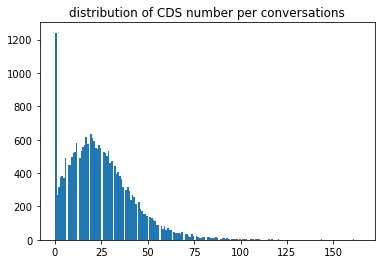

In [23]:
vc = df_pre["cds sums"]
plt.figure()
plt.hist(vc,bins=190)
plt.title('distribution of CDS number per conversations')

In [81]:
pos_cds

,I tend to kill myself;,I can't take my pain anymore;,I am able to kill myself;,I am a burden to others;,I feel like I'm stuck;,I have the will to live;,I'm hopeless;,I don't belong anywhere;,I feel like I've given up;,cds sums
event_id,,,,,,,,,,
cl000000,6.0,7.0,7.0,7.0,7.0,1.0,7.0,7.0,7.0,12.0
cl000001,1.0,7.0,1.0,7.0,7.0,5.0,7.0,7.0,7.0,32.0
cl000003,6.0,7.0,5.0,5.0,7.0,4.0,7.0,7.0,4.0,40.0
cl000004,7.0,7.0,7.0,7.0,7.0,1.0,7.0,7.0,7.0,71.0
cl000005,4.0,7.0,2.0,1.0,7.0,6.0,7.0,7.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...,...
cl024849,6.0,5.0,4.0,6.0,6.0,4.0,5.0,4.0,5.0,23.0
cl024850,3.0,2.0,2.0,6.0,6.0,2.0,5.0,2.0,5.0,16.0
cl024851,4.0,2.0,2.0,6.0,6.0,3.0,6.0,5.0,4.0,21.0


In [73]:
from scipy.stats import ttest_ind

p_vals = []
for col in pos_cds.columns:
    if col == 'cds sums': continue
    data1 = pos_cds[col]
    data2 = null_cds[col]
    stat, p = ttest_ind(data1, data2)
    if p < 0.05:
        p_vals.append("pass")
    else:
        p_vals.append("reject")
    

In [80]:
mean_diff = np.mean(pos_cds) - np.mean(null_cds)
mean_diff_df = pd.DataFrame(columns=['mean difference','ttest 0.05 p-value'])
mean_diff_df['mean difference'] = mean_diff[0:9]
mean_diff_df['ttest 0.05 p-value'] = p_vals
mean_diff_df = mean_diff_df.style.background_gradient(cmap=cm).set_precision(2)
mean_diff_df

<ipython-input-80-117e0feea788>:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  mean_diff_df = mean_diff_df.style.background_gradient(cmap=cm).set_precision(2)


,mean difference,ttest 0.05 p-value
I tend to kill myself;,0.28,pass
I can't take my pain anymore;,0.23,pass
I am able to kill myself;,0.12,pass
I am a burden to others;,0.28,pass
I feel like I'm stuck;,0.23,pass
I have the will to live;,-0.17,pass
I'm hopeless;,0.24,pass
I don't belong anywhere;,0.04,reject
I feel like I've given up;,0.11,pass


In [105]:

all_corrs = pos_cds.corr()

cm = sns.diverging_palette(120, 220, s=80, l=55, n=9, as_cmap=True)

a = all_corrs.loc['cds sums'].drop('cds sums')
a.name = "cds sum correlation"
a = pd.DataFrame(a).style.background_gradient(cmap=cm).set_precision(2)
a

<ipython-input-105-e7c3fb7e43c6>:7: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  a = pd.DataFrame(a).style.background_gradient(cmap=cm).set_precision(2)


,cds sum correlation
I tend to kill myself;,0.00
I can't take my pain anymore;,0.05
I am able to kill myself;,-0.04
I am a burden to others;,0.06
I feel like I'm stuck;,0.09
I have the will to live;,-0.05
I'm hopeless;,0.09
I don't belong anywhere;,0.04
I feel like I've given up;,0.04
